📌 Problem Statement

With the growth of digital communication, spam emails have become a major issue, ranging from unwanted advertisements to malicious phishing attempts. Traditional rule-based filters often fail to capture the evolving patterns of spam.

The objective of this project is to implement an intelligent text classification system that automatically distinguishes between Spam and Non-Spam emails. This project uses Recurrent Neural Networks (RNN) and Long Short-Term Memory (LSTM) models with Keras/TensorFlow to capture the sequential nature of email text.

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import kagglehub
import os

In [2]:
path = kagglehub.dataset_download("meruvulikith/190k-spam-ham-email-dataset-for-classification")
csv_file=os.path.join(path,'spam_Emails_data.csv')
data=pd.read_csv(csv_file)
data.head()

Using Colab cache for faster access to the '190k-spam-ham-email-dataset-for-classification' dataset.


,label,text
0,Spam,viiiiiiagraaaa\nonly for the ones that want to...
1,Ham,got ice thought look az original message ice o...
2,Spam,yo ur wom an ne eds an escapenumber in ch ma n...
3,Spam,start increasing your odds of success & live s...
4,Ham,author jra date escapenumber escapenumber esca...


In [3]:
data.shape

(193852, 2)

In [4]:
data.duplicated().sum()

np.int64(0)

In [5]:
data.isnull().sum()

,0
label,0
text,2


In [6]:
data.dropna(inplace=True)

In [7]:
data['label'].value_counts()

,count
label,
Ham,102159
Spam,91691


In [8]:
# lets see a text for example
text=data['text'][10]
text

'hey there - - life sounds horribly busy . i figured it was .\ndon \' t worry about me - - i just thought we should get things moving - - since\nnow i have officially been replaced , and it has been announced to my direct\nreports here in london . fernley ( not sure if you have spoken to him ) is\nanxious to put an announcement out to enron europe that phillip lord and i\nare leaving and that melissa will be stepping in to replace us .\nsince phillip already has a place to go , it would be nice if we could at\nleast say that i am going to north america energy ops , or something - - even\nif we don \' t have all of the details worked out .\ni am not sure if you want me to come over and meet some of your commercial "\ncustomers " - - - also - i have never met delainey ( i don \' t think ) - - but\nmaybe knowing frevert well is enough . i am planning to come in november\n( first half ) to work on europe \' s plan and coordinate with brent , wes and the\nother groups under frevert , so may

#### Our email messages contain a lot of unnecessary characters, which need to be cleaned before further processing

In [9]:
def clean_text(text):
  text=text.lower()
  text=re.sub(r'[^A-Za-z0-9\s]','',text) # reove any extra white spaces
  text=' '.join(text.split())
  return text

In [10]:
clean_text(text)

'hey there life sounds horribly busy i figured it was don t worry about me i just thought we should get things moving since now i have officially been replaced and it has been announced to my direct reports here in london fernley not sure if you have spoken to him is anxious to put an announcement out to enron europe that phillip lord and i are leaving and that melissa will be stepping in to replace us since phillip already has a place to go it would be nice if we could at least say that i am going to north america energy ops or something even if we don t have all of the details worked out i am not sure if you want me to come over and meet some of your commercial customers also i have never met delainey i don t think but maybe knowing frevert well is enough i am planning to come in november first half to work on europe s plan and coordinate with brent wes and the other groups under frevert so maybe i can meet some people then would love to discuss monday is fine as i am sure today will

In [11]:
data['text']=data['text'].apply(clean_text)  #cleaned the text

In [12]:
# lets map the target label Ham:0, Spame:1
data['label']=data['label'].map({'Ham':0,'Spam':1})

In [13]:
print(f"Numbers of class 0 : {sum(data['label']==0),} and % {sum(data['label']==0)/(sum(data['label']==0)+sum(data['label']==1))*100:.2f}%")

print(f"Numbers of class 1 : {sum(data['label']==1),} and % {sum(data['label']==1)/(sum(data['label']==0)+sum(data['label']==1))*100:.2f}%")

Numbers of class 0 : (102159,) and % 52.70%
Numbers of class 1 : (91691,) and % 47.30%


In [58]:
# we can clearly see our dataset is not imbalanced....

In [14]:
data.head()

,label,text
0,1,viiiiiiagraaaa only for the ones that want to ...
1,0,got ice thought look az original message ice o...
2,1,yo ur wom an ne eds an escapenumber in ch ma n...
3,1,start increasing your odds of success live sex...
4,0,author jra date escapenumber escapenumber esca...


In [15]:
import tensorflow
from  tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import SimpleRNN, LSTM, Embedding, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [16]:
x=data['text']
y=data['label']

In [17]:
max_words=10000 # no of words in vocab
max_len=100 # max sentence length

In [18]:
tokenizer=Tokenizer(num_words=max_words,oov_token='<OOV>')
tokenizer.fit_on_texts(x)  # build vocab
x_sequences=tokenizer.texts_to_sequences(x)
print(x_sequences[0][:20])
x_padded=pad_sequences(x_sequences,maxlen=max_len,padding='post',truncating='post')
print(x_padded[0][:20])

[1, 122, 10, 3, 1775, 16, 143, 4, 115, 344, 1, 1, 1, 1, 1923, 3815, 1, 1, 1, 1]
[   1  122   10    3 1775   16  143    4  115  344    1    1    1    1
 1923 3815    1    1    1    1]


In [19]:
from sklearn.model_selection import train_test_split

In [20]:
# lets divide into train and test
x_train, x_test, y_train, y_test=train_test_split(x_padded,y,test_size=0.2,random_state=42,stratify=y)

In [21]:
def create_rnn_model():
  model=Sequential([
      # embedding layer
      Embedding(input_dim=max_words,output_dim=128),
      # rnn layer
      SimpleRNN(units=64,return_sequences=False),

      # dropout layer

      Dropout(rate=0.5),

      # dense layer
      Dense(64,activation='relu'),

      Dense(1,activation='sigmoid') ])


  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
  return model

In [22]:
rnn_model=create_rnn_model()

In [23]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping=EarlyStopping(patience=5,restore_best_weights=True,monitor='val_loss')
lr_decay=tensorflow.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=3)

In [24]:
rnn_history=rnn_model.fit(x_train,y_train,epochs=50,validation_data=(x_test,y_test),callbacks=[early_stopping,lr_decay],batch_size=128)

Epoch 1/50
1212/1212 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.8413 - loss: 0.3295 - val_accuracy: 0.9698 - val_loss: 0.0958 - learning_rate: 0.0010
Epoch 2/50
1212/1212 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.9684 - loss: 0.0958 - val_accuracy: 0.9764 - val_loss: 0.0714 - learning_rate: 0.0010
Epoch 3/50
1212/1212 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.9828 - loss: 0.0555 - val_accuracy: 0.9765 - val_loss: 0.0787 - learning_rate: 0.0010
Epoch 4/50
1212/1212 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.9515 - loss: 0.1109 - val_accuracy: 0.7408 - val_loss: 0.4655 - learning_rate: 0.0010
Epoch 5/50
1212/1212 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.7228 - loss: 0.4708 - val_accuracy: 0.9567 - val_loss: 0.1188 - learning_rate: 0.0010
Epoch 6/50
1212/1212 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.9734 - loss: 0.0809 - val_accuracy: 0.9679 - val_loss: 0.0979 - learning_rate: 1.0000e-04
Epoch 7/50
1212/1212 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - ac

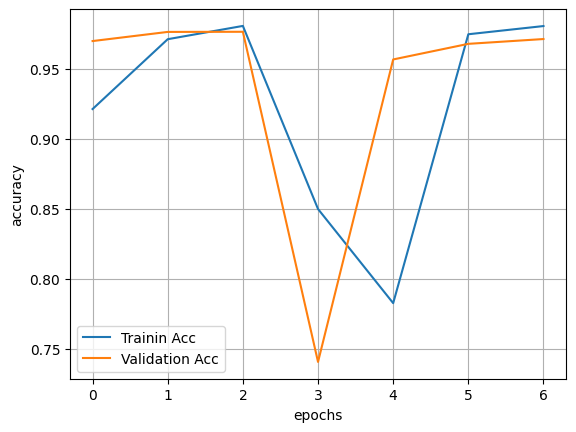

In [25]:
plt.plot(figsize=(10,7))
plt.plot(rnn_history.history['accuracy'],label='Trainin Acc')
plt.plot(rnn_history.history['val_accuracy'],label='Validation Acc')
plt.legend()
plt.grid(True)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

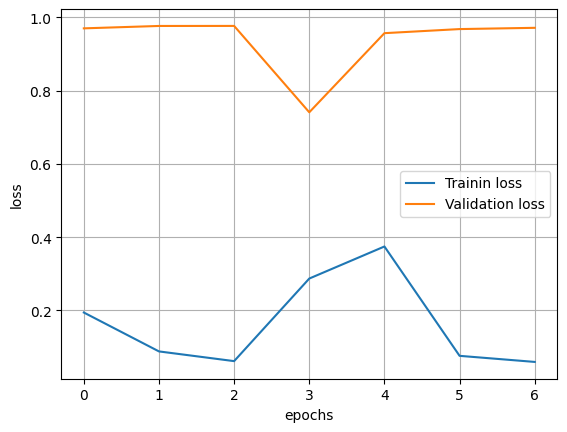

In [26]:
plt.plot(figsize=(10,7))
plt.plot(rnn_history.history['loss'],label='Trainin loss')
plt.plot(rnn_history.history['val_accuracy'],label='Validation loss')
plt.legend()
plt.grid(True)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

#### We can clearly see that our RNN model is not performing well, as its accuracy does not improve and loss does not decrease over the training epochs. Let's try using an LSTM.

In [27]:
def create_lstm_model():
  model=Sequential([
      # embedding layer
      Embedding(input_dim=max_words,output_dim=128),
      # rnn layer
      LSTM(units=128,return_sequences=False),

      # dropout layer

      Dropout(rate=0.5),

      # dense layer
      Dense(64,activation='relu'),

      Dense(1,activation='sigmoid') ])


  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
  return model

In [28]:
lstm_model=create_lstm_model()
lstm_history=lstm_model.fit(x_train,y_train,epochs=50,validation_data=(x_test,y_test),callbacks=[early_stopping,lr_decay],batch_size=128)

Epoch 1/50
1212/1212 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.7933 - loss: 0.4603 - val_accuracy: 0.8700 - val_loss: 0.3177 - learning_rate: 0.0010
Epoch 2/50
1212/1212 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.9184 - loss: 0.2194 - val_accuracy: 0.9082 - val_loss: 0.2943 - learning_rate: 0.0010
Epoch 3/50
1212/1212 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.9540 - loss: 0.1412 - val_accuracy: 0.9665 - val_loss: 0.0955 - learning_rate: 0.0010
Epoch 4/50
1212/1212 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.9787 - loss: 0.0693 - val_accuracy: 0.9759 - val_loss: 0.0764 - learning_rate: 0.0010
Epoch 5/50
1212/1212 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.9863 - loss: 0.0472 - val_accuracy: 0.9786 - val_loss: 0.0679 - learning_rate: 0.0010
Epoch 6/50
1212/1212 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.9906 - loss: 0.0335 - val_accuracy: 0.9788 - val_loss: 0.0650 - learning_rate: 0.0010
Epoch 7/50
1212/1212 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accura

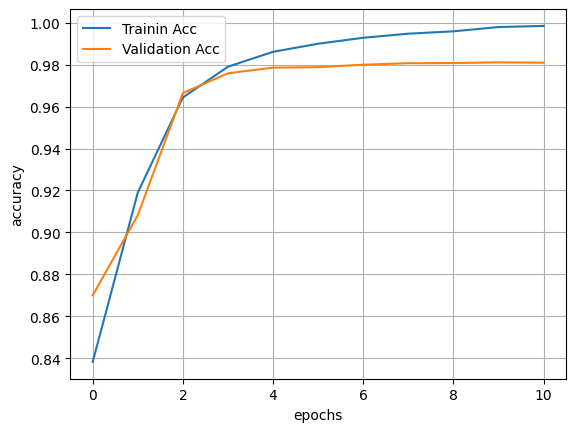

In [29]:
plt.plot(figsize=(10,7))
plt.plot(lstm_history.history['accuracy'],label='Trainin Acc')
plt.plot(lstm_history.history['val_accuracy'],label='Validation Acc')
plt.legend()
plt.grid(True)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

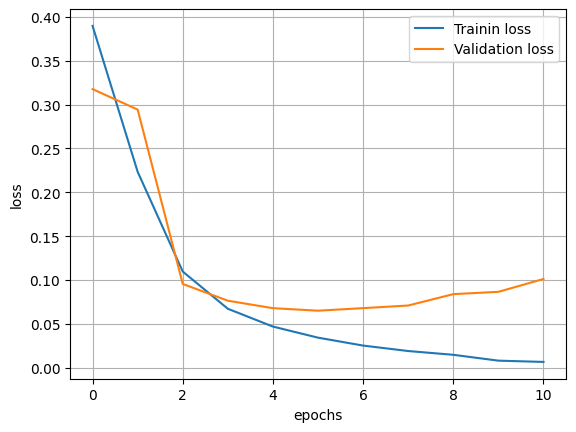

In [30]:
plt.plot(figsize=(10,7))
plt.plot(lstm_history.history['loss'],label='Trainin loss')
plt.plot(lstm_history.history['val_loss'],label='Validation loss')
plt.legend()
plt.grid(True)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [35]:
test_loss,test_acc=lstm_model.evaluate(x_test,y_test)
print(f"Test accuracy : {test_acc*100:.2f}%")

1212/1212 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9787 - loss: 0.0641
Test accuracy : 97.88%


#### As we can see, the LSTM model’s accuracy has increased and its loss has decreased over thr epochs, indicating better performance. The graph also clearly shows that it is performing better than the RNN.

In [31]:
lstm_model.save('lstm_spam_detection_model.keras') # save the lstm model

In [32]:
import tensorflow as tf
loaded_model=tf.keras.models.load_model('lstm_spam_detection_model.keras')

In [33]:
import pickle # save the tokenizer

with open("spam_model_tokenizer.pkl",'wb') as f:
    pickle.dump(tokenizer, f)
with open("spam_model_tokenizer.pkl", 'rb') as f:
  loaded_tokenizer = pickle.load(f)

#### let's take some example and see how our model is performing...

In [48]:
spam_emails = [
    "Subject: Urgent: Verify Your Account Today\n\nDear Customer,\nWe noticed unusual activity in your account. Please login immediately via the secure link below to avoid suspension: http://secure-bank-login.verify-now.com\nFailure to do so may result in permanent account closure.\nRegards, Bank Security Team",

    "Subject: Congratulations! You’ve been shortlisted!\n\nDear Applicant,\nYour profile matches our requirements. To secure your high-paying remote position (₹10-15 LPA), provide your bank account and Aadhaar details immediately. Limited slots available!\nBest, HR Team",

    "Subject: Unlock your prize now!\n\nYou have won a $5000 gift card! Click the link to claim: http://fakeprizes.com/win-now. Hurry, offer expires soon!",

    "Subject: Final Notice: Tax Refund Pending\n\nDear Taxpayer,\nOur records show you have a pending refund. Submit your personal and banking information here: http://tax-refund-online.com before 24 hours to get your refund.",

    "Subject: Limited Offer: Get Paid Work from Home\n\nEarn ₹50,000/week from your home. No experience required. Sign up here: http://easy-income.com/apply-now"
]


In [49]:
def predict_senteces(sent):
  sent=clean_text(sent)
  sequence=loaded_tokenizer.texts_to_sequences([sent])
  padding=pad_sequences(sequence,maxlen=max_len,padding='post',truncating='post')
  prediction=loaded_model.predict(padding)
  pred_class=1 if prediction>0.5 else 0
  if pred_class==1:
    return 'Spam'
  else:
    return 'Non Spam'

In [50]:
for sent in spam_emails:
  result=predict_senteces(sent)
  print(f"Sentence : {sent}\nPrediction : {result}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Sentence : Subject: Urgent: Verify Your Account Today

Dear Customer,
We noticed unusual activity in your account. Please login immediately via the secure link below to avoid suspension: http://secure-bank-login.verify-now.com
Failure to do so may result in permanent account closure.
Regards, Bank Security Team
Prediction : Spam

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Sentence : Subject: Congratulations! You’ve been shortlisted!

Dear Applicant,
Your profile matches our requirements. To secure your high-paying remote position (₹10-15 LPA), provide your bank account and Aadhaar details immediately. Limited slots available!
Best, HR Team
Prediction : Spam

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Sentence : Subject: Unlock your prize now!

You have won a $5000 gift card! Click the link to claim: http://fakeprizes.com/win-now. Hurry, offer expires soon!
Prediction : Spam

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Sentence : Subject: Final Notice: Tax Refund P

In [51]:
non_spam_emails = [

    "Subject: Project Update Meeting Tomorrow\n\nHi Team,\nJust a reminder about the project sync-up at 10:00 AM tomorrow. Please review the attached documents before the meeting.\nThanks, Amit",

    "Subject: Exam Results Published\n\nDear Student,\nYour semester 2 results are now available on the student portal. Please login using your credentials to view your grades.\nRegards, Examination Office, XYZ University",

    "Subject: Appointment Confirmation\n\nHello Priya,\nYour appointment with Dr. Mehta is confirmed for 11:30 AM on 15th September. Please arrive 10 minutes early.\nThank you, City Hospital",

    "Subject: Team Lunch Invitation\n\nHi Everyone,\nWe are organizing a team lunch on Friday at 1 PM. Please RSVP by Thursday so we can make reservations.\nRegards, Ramesh",

    "Subject: Subscription Renewal Confirmation\n\nDear User,\nYour subscription for the Premium Plan has been successfully renewed. No further action is required.\nThanks, Streaming Service Team"
]


In [52]:
for sent in non_spam_emails:
  result=predict_senteces(sent)
  print(f"Sentence : {sent}\nPrediction : {result}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Sentence : Subject: Project Update Meeting Tomorrow

Hi Team,
Just a reminder about the project sync-up at 10:00 AM tomorrow. Please review the attached documents before the meeting.
Thanks, Amit
Prediction : Non Spam

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Sentence : Subject: Exam Results Published

Dear Student,
Your semester 2 results are now available on the student portal. Please login using your credentials to view your grades.
Regards, Examination Office, XYZ University
Prediction : Non Spam

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Sentence : Subject: Appointment Confirmation

Hello Priya,
Your appointment with Dr. Mehta is confirmed for 11:30 AM on 15th September. Please arrive 10 minutes early.
Thank you, City Hospital
Prediction : Non Spam

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Sentence : Subject: Team Lunch Invitation

Hi Everyone,
We are organizing a team lunch on Friday at 1 PM. Please RSVP by Thursday so we can make reservations.
Regards

In [55]:
test_sentences = [
    # Non-Spam
    "Hi Sarah, I just wanted to confirm our meeting on Thursday at 3 pm. The client will be joining us via Zoom, so please make sure the presentation deck is ready by tomorrow evening. Let me know if you need any last-minute support.",
    "Dear Team, as discussed in the last sprint review, we need everyone to update their weekly progress reports by EOD Friday. This will help us finalize the tasks for the upcoming release cycle. Please reach out if you face blockers.",
    "Hello Professor, I’ve attached my revised assignment based on your feedback. I also included an additional case study example to strengthen the analysis. Please let me know if there are further improvements I can make.",
    "Hi David, just a quick reminder about the family get-together next weekend at Grandma’s place. Everyone is expected to bring a dish, so could you confirm if you’ll be making the pasta this time? Looking forward to seeing you all.",

    # Spam
    "Congratulations! You have been chosen as the lucky winner of our grand prize worth $10,000. To claim your reward, simply click on the link below and enter your personal details. Hurry, this exclusive offer is valid only for the next 24 hours.",
    "Act now to secure your spot in our limited-time investment scheme that guarantees 300% returns in just two months. No prior knowledge or experience is required, but spaces are filling fast, so don’t miss this once-in-a-lifetime opportunity.",
    "Your account has been flagged for suspicious activity and may be permanently suspended. To restore access, please verify your login details immediately by clicking the secure link provided in this email. Failure to act within 12 hours may result in loss of access.",
    "Attention! Our records indicate that you are entitled to unclaimed insurance benefits worth thousands of dollars. Please provide your personal information immediately to ensure fast processing of your claim, otherwise your benefits may expire."
]


In [56]:
for sent in test_sentences:
  result=predict_senteces(sent)
  print(f"Sentence : {sent}\nPrediction : {result}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Sentence : Hi Sarah, I just wanted to confirm our meeting on Thursday at 3 pm. The client will be joining us via Zoom, so please make sure the presentation deck is ready by tomorrow evening. Let me know if you need any last-minute support.
Prediction : Non Spam

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Sentence : Dear Team, as discussed in the last sprint review, we need everyone to update their weekly progress reports by EOD Friday. This will help us finalize the tasks for the upcoming release cycle. Please reach out if you face blockers.
Prediction : Non Spam

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Sentence : Hello Professor, I’ve attached my revised assignment based on your feedback. I also included an additional case study example to strengthen the analysis. Please let me know if there are further improvements I can make.
Prediction : Non Spam

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Sentence : Hi David, just a quick reminder about the family get-tog

In [57]:
sent='Dear Candidate, following our discussion last week, your profile has been moved to the next round of evaluation for the Data Analyst role. Our HR team will share the Zoom link and interview schedule by tomorrow evening. Please ensure you are available during the mentioned slot, as rescheduling may not be possible.'


predict_senteces(sent)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


'Non Spam'

## Note: After testing on multiple sentences, we can see that our LSTM model is correctly classifying spam and non-spam messages."